In [1]:
import numpy as np
import networkx as nx
import sympy
import matplotlib.pyplot as plt
from sympy.utilities.iterables import multiset_permutations
import cirq
import scipy
import scipy.optimize as optimize
import timeit
import os
import pandas as pd

In [2]:
#defining Pauli-Matrices
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.array([[1,0],[0,1]])

"""function for construncting hamiltonian manually
INPUT:
    -N : amount of qubits
    -interactions: A list of lists that contain interactions and corresponding coupling strengths.
                Example: [['P1P2...PN',J1], ['P1P2...PN',J2],....], where P is one of {X,Y,Z,I}.
                One can leave identities out of the expression. J is the strength of the interaction and thus a number.
OUTPUT:
    -H: Hamiltonian (2^N,2^N)-d array
"""

   
def H_manual(N,interactions):
    H = np.zeros((2**N,2**N)).astype('complex128')
    for i in interactions:
        Kron = 1
        paulis = []
        positions = []
        
        #creating lists of operators and corresponding positions
        prev_int = False #value that represents if previous character was an integer
        for k in i[0]:
            if k.isdigit():
                if not prev_int:
                    positions.append(k)
                else:
                    positions[-1] = 10*positions[-1]+k
                prev_int = True
            else:
                paulis.append(k)
                prev_int = False
        

        #computes tensorproduct for every interaction
        n=0
        for j in range(N):
            
            if j+1 == int(positions[n]):
                M = eval(paulis[n])
                if n+1 < len(positions):
                    n+=1
            else:
                M = I
            Kron = np.kron(Kron,M)
            
        H += Kron*i[1]
    return H




#I thought this was useful, but it didn't really end up like that.
"""function for construncting hamiltonian with the help of a pattern
INPUT:
    -N : amount of qubits
    -operation: operation that will be applied to every qubit available
                must be a list of the form ['P1P2...PN',J], where P is one of {X,Y,Z,I}.
                One can leave identities out of the expression. J is the strength of the interaction.
    -boundary: default is 'open', which will repeat the given operation untill 
               a non-identity operation acts on the N-th qubit. One can also input 'periodic', which 
               iterates over all qubits and lets P(N+1) act on P1
OUTPUT:
    -H: Hamiltonian (2^N,2^N)-d array
"""


def H_pattern(N, operation, boundary = 'open'):
    H = np.zeros((2**N,2**N)).astype('complex128')
    #creating lists of operators and corresponding positions
    paulis = []
    positions = []
    prev_int = False
    for k in operation[0]:
        if k.isdigit():
            if not prev_int:
                positions.append(k)
            else:
                positions[-1] += k
            prev_int = True
        else:
            paulis.append(k)
            prev_int = False
        

    if boundary == 'open':
        for i in range(N-int(positions[-1])+1):
            Kron = 1
            n=0
            for j in range(N):
                
                if j+1 == int(positions[n])+i:
                    M = eval(paulis[n])
                    if n+1 < len(positions):
                        n+=1
                else:
                    M = I
                Kron = np.kron(Kron,M)
            H+= Kron*operation[1]
            

    elif boundary == 'periodic':
        for i in range(N):
            Kron = 1
            
            #Make sure periodic iterations are done correctly
            positions_periodic = ((np.array(list(map(int, positions)))+i))
            positions_periodic = np.where(positions_periodic > N, positions_periodic%N,positions_periodic)
            Tuple= list(zip(paulis,positions_periodic))
            paulis = [tuple[0] for x in np.sort(positions_periodic) for tuple in Tuple if tuple[1] == x]
            positions_periodic = np.sort(positions_periodic)
            print(positions_periodic)
            n=0

            for j in range(N):
            
                if j+1 == int(positions_periodic[n]):
                    M = eval(paulis[n])
                    if n+1 < len(positions):
                        n+=1
                else:
                    M = I
                Kron = np.kron(Kron,M)
            H+= Kron*operation[1]

            
        
    return H

                
        

In [3]:
class inter:
    def __init__(self, N, interactions, PT_order=None, P_n=None):
        self.N = N
        self.interactions = interactions
        self.PT_order = PT_order
        self.P_n = P_n
    """"
    INPUT:
    -interactions in the given format
    OUTPUT:
    -returns 2 lists of same length, on containing operations, the other containing the corresponding positions.
    """
    def split(self):
        paulis = []
        positions = []
        for i in range(len(self.interactions)):
            pauli_lst = []
            pos_lst = []

        
            #creating lists of operators and corresponding positions
            prev_int = False
            for k in self.interactions[i][0]:
                if k.isdigit():
                    if not prev_int:
                        pos_lst.append(k)
                    else:
                        pos_lst[-1] += k
                    prev_int = True
                else:
                    pauli_lst.append(k)
                    prev_int = False
            paulis.append(pauli_lst)
            positions.append(pos_lst)
        return positions, paulis
    """"
    INPUT:
    -k: list with same length of interactions, where k[i] represents how many times interactions[i] is activated
    OUTPUT:
    - state: array of length N, representing the state after applying k on ket(0).
    -a: {0,1}: 0 if resulting state is real, 1 if resulting state is imaginary.
    """
    
    def state(self, k):
        positions = self.split()[0]
        paulis = self.split()[1]
        starting_state = -np.ones(self.N)
        a = -1
        for i in range(len(k)):
            if k[i] %2 != 0:
                for j in range(len(positions[i])):
                    if paulis[i][j] == 'X':
                        starting_state[int(positions[i][j])-1] *= -1
                    elif paulis[i][j]=='Y':
                        starting_state[int(positions[i][j])-1] *= -1
                        a *=-1
                    
                        
        a = (a+1)/2
        state = (starting_state+1)/2
        return a, list(state)
        """"
    INPUT:
    -k: list with same length of interactions, where k[i] represents how many times interactions[i] is activated
    OUTPUT:
    -True or False, True if the diagrammatic corresponding to k is connected, False if the diagrammatic is disconnected.
    """
    
    def con(self,k):
        positions = self.split()[0]
        connect_on = []
        for i in range(len(k)):
                if k[i] != 0:
                    connect_on.append(positions[i])
        v = connect_on[0]
        j = 0
        while len(connect_on)!= j:
            connect_set = set(connect_on[j])
            v_set = set(v)

            if (v_set&connect_set):
                v=v+connect_on.pop(j)
                j=0
                if connect_on == []:
                    return True
            else:
                j+=1
        return False
    
    """"
    INPUT:
    -PT_order: integer, representing up till which perturbation theory one wants to consider.
    OUTPUT:
    -k_vecs: list of allowed k's. Where allowed means, with a connected diagram 
    and not with an order greater or equal to a k that produces exactly the same state.
    """
    
    def k_vecs(self):
        k_length = len(self.interactions)
        k_vecs = []
        k_vecs_allowed = []
        states = [self.state(np.zeros(k_length))]
        max_gates = min([self.PT_order, 2*k_length])
        for i in range(1,max_gates+1):
            k = []
            order = i
            if order%2==1:
                k = k+[1]
                order -= 1
            p = order/2
            k +=int(p)*[2]+int(k_length-len(k)-p)*[0]
            k_vecs.append(k)
            k_1 = k.copy()
            
            while 2 in k_1 and 0 in k_1:
                k_1.remove(2)
                k_1.remove(0)
                k_1+=[1,1]
                k_add= k_1.copy()
                k_vecs.append(k_add)
        for i in k_vecs:
            perms = list(multiset_permutations(i))
            for j in perms:
                if self.con(j) and (self.state(j) not in states):
                    states.append(self.state(j))
                    k_vecs_allowed.append(j)
        return(k_vecs_allowed)
    """"
    INPUT:
    -PT_order: integer, representing up till which perturbation theory one wants to consider.
    OUTPUT:
    -graphs of all allowed k's up till the given order.
    """
    
    def draw_diagrammatics(self):
        vecs = self.k_vecs()
        for i in vecs:
            graph(i,self.N,self.interactions).make_graph()
            plt.show()
    def build_circuit(self):
        vecs = self.k_vecs()
        if self.P_n == 'max':
            self.P_n = len(vecs)
        pauli_operations = []
        theta = P_n*[0]
        for i in range(self.P_n):
            theta[i] = sympy.Symbol('theta_%s'%i)
            a, state = self.state(vecs[i])
            state = np.array(state)
            pauli_operations.append([QCA(self.N, state, a, theta[i]).pauli_operator()])
        return pauli_operations
    
    def print_circuit(self):
        circuit = cirq.Circuit(self.build_circuit())
        print(circuit.to_text_diagram(transpose= True))
     
    
    
    
        
    def P_tensorproducts(self):
        k = self.k_vecs()
        P_strings = []
        
        for i in range(self.P_n):
            state = self.state(k[i])
            T = 1
            complx = False
            if state[0] == 1:
                complx = True
            for j in state[1]:
                if j == 1:
                    if not complx:
                        M = Y
                        complx = True
                    else:
                        M = X
                else:
                    M = I
                T = np.kron(T,M)
            P_strings.append(T)
        return P_strings

In [4]:
class MyBounds(object):
    def __init__(self, xmax=np.pi, xmin=-np.pi ):
        self.xmax = xmax
        self.xmin = xmin
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= np.array(len(x)*[self.xmax])))
        tmin = bool(np.all(x >= np.array(len(x)*[self.xmin])))
        return tmax and tmin

In [111]:
def exact_eigen(H):
    eigen = np.linalg.eig(H)
    index = np.argmin(eigen[0])
    ground_energy = eigen[0][index]
    ground_state = np.round(eigen[1][:,index],3)
    return ground_state, ground_energy

def QCA_ansatz(theta,N,P_strings):
    matrix = np.identity(2**N).astype('complex128')
    for i in range(len(P_strings)):
        O = scipy.sparse.linalg.expm(1j*theta[i]*P_strings[i])
        matrix = O.dot(matrix)

    return matrix
    
    
def UCC_ansatz(theta,N,P_strings):
    matrix = np.zeros((2**N,2**N)).astype('complex128')
    for i in range(len(P_strings)):
        matrix += theta[i]*P_strings[i]
    matrix = scipy.sparse.linalg.expm(1j*matrix)
    return matrix

def UCC_Trot_con(theta,N,P_strings,Trot_order = 2):
    a = QCA_ansatz(theta, N, P_strings)
    matrix = a
    for i in range(Trot_order-1):
        matrix = matrix.dot(a)
    return matrix
def UCC_Trot_uncon(theta,N,P_strings, N_first = None):
    matrix = QCA_ansatz(theta[:N_first],N, P_strings[:N_first])
    a = len(theta)%N_first
    for i in range(1,int(np.floor(len(theta)/N_first))):
        matrix1 = QCA_ansatz(theta[i*N_first:(i+1)*N_first],N,P_strings[:N_first])
        matrix = matrix.dot(matrix1)
    matrix2 = QCA_ansatz(theta[-a:],N, P_strings[:a])
    matrix = matrix.dot(matrix2)
    return matrix

def hybrid(theta, N, P_strings, N_first, switch):
    length = len(P_strings)
    if switch < length:
        matrix1 = QCA_ansatz(theta[:switch], N,P_strings[:switch])
        matrix2 = UCC_Trot_uncon(theta[switch:], N, P_strings[:length-switch],N_first)
        matrix = matrix2.dot(matrix1)
    else:
        matrix = QCA_ansatz(theta, N,P_strings)
    return matrix

def Trot_error(H, N, P_strings, order):
    theta = VQa(H, ['QCA'], N, P_strings)[2]
    matrix = UCC_Trot_con(theta/order, N, P_strings, order)
    psi = np.zeros(2**N)
    psi[0]=1
    psi_final = matrix.dot(psi)
    Energy = np.transpose((np.conj(psi_final)).dot(H.dot(psi_final)))
    return(Energy)
    
    
    
def Psi(theta, ansatz, N, P_strings):
    psi = np.zeros(2**N)
    psi[0]=1
    if ansatz[0] == 'QCA':
        U = QCA_ansatz(theta, N, P_strings)
    elif ansatz[0] == 'UCC':
        U = UCC_ansatz(theta, N, P_strings)
    elif ansatz[0] == 'UCC_Trot_con':
        U = UCC_Trot_con(theta, N, P_strings,ansatz[1])
    elif ansatz[0]=='UCC_Trot_uncon':
        U = UCC_Trot_uncon(theta, N, P_strings,ansatz[1])
    elif ansatz[0]=='Hybrid':
        U = hybrid(theta, N , P_strings, ansatz[1],ansatz[2])
    else:
        U = np.identity(2**N)
        print('invalid ansatz')
            
    psi = U.dot(psi)
    return(psi)
    
def energy(theta,H,ansatz, N, P_strings):
    psi = Psi(theta,ansatz, N, P_strings)
    return np.real(np.transpose((np.conj(psi)).dot(H.dot(psi))))
    
def VQa(H, ansatz,N, P_strings,initial_guess = np.array([None])):
    if initial_guess.any() == None or len(initial_guess)!= len(P_strings):
        initial_guess = len(P_strings)*[0]
    result = optimize.minimize(energy, initial_guess,jac = False, args = (H,ansatz,N,P_strings))#minimizer_kwargs = {"method" :'dogleg',"args":(H,ansatz,N,P_strings)}, jac = False, niter = 1, accept_test = MyBounds())
    ground_state = np.round(Psi(result.x, ansatz,N, P_strings),3)
    ground_energy = result.fun
    return ground_state, ground_energy, result.x, result.hess_inv

In [6]:
def findCombinationsUtil(li, arr, index, num, reducedNum):
    z = []
    if (reducedNum < 0): 
        return; 
    if (reducedNum == 0): 
  
        for i in range(index): 
            z = z + [arr[i]]
        li.append(z) 
        return;

    prev = 1 if(index == 0) else arr[index - 1]; 
  
    for k in range(prev, num + 1): 
          

        arr[index] = k; 
  
        findCombinationsUtil(li,arr, index + 1, num,  
                                 reducedNum - k); 
    return li
   
def k_all(N, interactions, order): 
      
    # array to store the combinations 
    # It can contain max n elements
    out = []
    k_length = len(interactions)
    for k in range(1, order):
        arr = [0] * k;
        output = []
        a =  findCombinationsUtil([], arr, 0, k, k);
        for i in a:
            if len(i)<= k_length:
                i = i.extend((k_length-len(i))*[0])
        for j in a:
            if len(j) == k_length:
                if inter(N, interactions).state(j)[1] != N*[0]:
                    output = output + list(multiset_permutations(j))
        out = out+ output
    return out

In [66]:
def sign(N, interactions, k1, k2):
    if not inter(N, interactions).con(list(np.array(k1)+np.array(k2))):
        return 1
    else:
        starting_state = -np.ones(N)
        sign1 = state_sign(N, interactions, starting_state, list(np.array(k1)+np.array(k2)))[2]
        state, sign2 = state_sign(N, interactions, starting_state, k2)[1:3]
        sign3 = state_sign(N, interactions, np.array(state), k1)[2]
        return (sign2*sign3)/sign1


def state_sign(N, interactions, starting_state, k):
    
    positions = inter(N, interactions).split()[0]
    paulis = inter(N, interactions).split()[1]

    a = -1
    sign = 1
    for i in range(len(k)):
        if k[i] %2 != 0:
            for j in range(len(positions[i])):
                if paulis[i][j] == 'X':
                    starting_state[int(positions[i][j])-1] *= -1
                elif paulis[i][j]=='Y':
                    starting_state[int(positions[i][j])-1] *= -1
                    a *=-1
                    if starting_state[int(positions[i][j])-1] == 1:
                        sign*=-1
                elif paulis[i][j]=='Z':
                    if starting_state[int(positions[i][j])-1] == 1:
                        sign*=-1
                    
                        
    a = (a+1)/2
    state = (starting_state+1)/2
    return a, list(state), sign


def k_vecs(N, interactions, PT_order):
    k_length = len(interactions)
    k_vecs = []
    k_vecs_allowed = []
    states = [inter(N, interactions, PT_order).state(np.zeros(k_length))]
    states2 = [inter(N, interactions, PT_order).state(np.zeros(k_length))]
    max_gates = min([PT_order, 2*k_length])
    for i in range(1,max_gates+1):
        k = []
        order = i
        if order%2==1:
            k = k+[1]
            order -= 1
        p = order/2
        k +=int(p)*[2]+int(k_length-len(k)-p)*[0]
        k_vecs.append(k)
        k_1 = k.copy()
        add = 0
        while 2 in k_1 and 0 in k_1:
            k_1.remove(2)
            k_1.remove(0)
            k_1+=[1,1]
            k_add = k_1.copy()
            k_vecs.append(k_add)
    for i in k_vecs:
        perms = list(multiset_permutations(i))
        for j in perms:
            if (inter(N, interactions, PT_order).state(j) not in states):
                states.append(inter(N, interactions, PT_order).state(j))
                if inter(N, interactions).con(j):
                    states2.append(inter(N, interactions, PT_order).state(j))
                k_vecs_allowed.append(j)
            else:
                if inter(N, interactions).con(j):
                    if inter(N, interactions, PT_order).state(j) not in states2:
                        states2.append(inter(N, interactions, PT_order).state(j))
                        k_vecs_allowed.append(j)
    return(k_vecs_allowed)

def coeffs(N, interactions, H_0, k_allowed):
    length = len(interactions)
    coef= {repr(length*[0]):1}
    states = {repr(length*[0]):[1]+(2**(N)-1)*[0]}
    E_0 = exact_eigen(np.array(H_0))[1]
    for i in k_allowed:
        J = interactions[0][1]
        som = sum(i)
        compl, state, sgn = state_sign(N,interactions,-np.ones(N), i)
        state_vec = sgn*1j**(compl)*J**som
        for z in range(N):
            if state[z]==0:
                state_vec = np.kron(state_vec, np.array([1,0]))
            else:
                state_vec = np.kron(state_vec, np.array([0,1]))
                
                
        sum1 = 0
        for j in range(len(i)):
            if i[j] > 0:
                #k prior state
                k_ = np.array(i)
                k_[j]+=-1
                c = coef.get(repr(list(k_)),0)
                #relative sign
                s = sign(N,interactions, k_, np.array(i)-k_)
                term1 = c*s
                magn = int(np.floor(np.sum(np.array(i))/2-1/2))
                k_s_0 = []
                sum2 = 0
                for m in range(1,magn+1):
                    k_s_0 = k_s_0 + list(multiset_permutations(m*[2]+(length-m)*[0]))
                for n in k_s_0:
                    n1 = np.array(n) - np.array(i)+k_
                    n2 = np.array(i) - np.array(n)
                    s1 = sign(N,interactions,np.array(i)-k_,n1)
                    s2 = sign(N,interactions, n2, np.array(n))
                    c1 = coef.get(repr(list(n1)),0)
                    c2 = coef.get(repr(list(n2)),0)
                    if c1==0 or c2 ==0:
                        pass
                        
                    sum2+= c1*c2*s1*s2
                sum1+= term1 - sum2
            else:
                pass
        E_k = np.real(np.transpose((np.conj(state_vec)).dot(H_0.dot(state_vec))))
        E = E_0 - E_k
        coef[repr(i)] = float(sum1/E)
        states[repr(i)] = list(state_vec)
    return coef, states

In [81]:
N = 4
J = -0.4
interactions_0 = [['Z1',-1.],['Z2',-1.],['Z3',-1.], ['Z4',-1]]
interactions = [["X1X2",J],['X2X3',J],["X3X4",J]]
H_0 = H_manual(N, interactions_0)
k_allowed = k_vecs(N, interactions, 10)
k_al = k_all(N, interactions, 5)
print(coeffs(N, interactions,H_0, k_al)[0])

{'[0, 0, 0]': 1, '[0, 0, 1]': -0.25, '[0, 1, 0]': -0.25, '[1, 0, 0]': -0.25, '[0, 1, 1]': 0.125, '[1, 0, 1]': 0.12187987519500779, '[1, 1, 0]': 0.125, '[1, 1, 1]': -0.09296996879875194, '[0, 1, 2]': -0.015625, '[0, 2, 1]': -0.015625, '[1, 0, 2]': -0.014844968798751947, '[1, 2, 0]': -0.015625, '[2, 0, 1]': -0.014844968798751947, '[2, 1, 0]': -0.015625, '[0, 0, 3]': 0.015625, '[0, 3, 0]': 0.015625, '[3, 0, 0]': 0.015625, '[1, 1, 2]': 0.02304748439937597, '[1, 2, 1]': 0.02342215005973685, '[2, 1, 1]': 0.02304748439937597, '[0, 1, 3]': -0.0078125, '[0, 3, 1]': -0.0078125, '[1, 0, 3]': -0.007807383353245616, '[1, 3, 0]': -0.0078125, '[3, 0, 1]': -0.007807383353245616, '[3, 1, 0]': -0.0078125}


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:126: ComplexWarning: Casting complex values to real discards the imaginary part


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:126: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[0.985+0.j 0.   +0.j 0.   +0.j 0.098+0.j 0.   +0.j 0.02 +0.j 0.099+0.j
 0.   +0.j 0.   +0.j 0.005+0.j 0.02 +0.j 0.   +0.j 0.098+0.j 0.   +0.j
 0.   +0.j 0.01 +0.j]
[0.98445525 0.         0.         0.09938083 0.         0.01987617
 0.09942998 0.         0.         0.00585759 0.02007306 0.
 0.09938083 0.         0.         0.01939441]


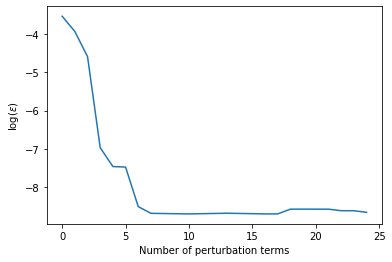

In [85]:
coef, states = coeffs(N, interactions,H_0, k_al)
terms = 25
H_1 = H_manual(N, interactions)
H = H_0+H_1
def pert_coefs(N, interactions, H, coef, states, terms):
    pert_states = np.zeros((len(coef), 2**N))
    counter = 0
    for i in coef:
        c = coef[i]
        sta = np.array(states[i])
        pert_states[counter, :] = (c*sta).astype('float64')
        counter +=1
    pert_states = np.cumsum(pert_states, axis = 0)
    pert_states = pert_states[:terms, :]
    pert_states = pert_states / np.linalg.norm(pert_states, axis=-1)[:, np.newaxis]
    return pert_states
    
pert_states = pert_coefs(N, interactions, H, coef, states, terms) 
eigenstate, ex = exact_eigen(H)
print(eigenstate)
NRG = [(np.real(np.transpose((np.conj(k)).dot(H.dot(k))))-ex)/ex for k in pert_states]
print(pert_states[-1])
plt.plot(list(range(terms)), np.log(np.array(NRG)))
plt.xlabel("Number of perturbation terms")
plt.ylabel("log($\epsilon$)")
plt.show()

In [84]:
"""Class that creates graph for certain k, corresponding to the given interactions

INPUT:
-k: list with same length of interactions, where k[i] represents how many times interactions[i] is activated
-interactions: A list of lists that contain interactions and corresponding coupling strengths.
Example: [['P1P2...PN',J1], ['P1P2...PN',J2],....], where P is one of {X,Y,Z,I}.
One can leave identities out of the expression. J is the strength of the interaction and thus a number.

-OUTPUT:
-graph
"""
class graph:
    def __init__(self, k, N,interactions):
        self.k= k
        self.interactions= interactions
        self.N = N
        self.G = nx.Graph()
    def Qubit_nodes(self):
        clrs = []
        for i in range(self.N):
            if inter(self.N,self.interactions).state(self.k)[1][i] == 1:
                self.G.add_node(i)
                clrs.append('black')
            else:
                self.G.add_node(i)
                clrs.append('white')
        
        nodes = list(range(self.N))
        bottom_ys = np.repeat(0,len(nodes))
        bottom_xs = np.linspace(0, 1, len(nodes))
        bottom_pos = np.column_stack([bottom_xs, bottom_ys])
        pos = dict(zip(nodes, bottom_pos))
        
        return pos, clrs
    
    def interactions_nodes(self):
        positions = inter(self.N,self.interactions).split()[0]
        paulis = inter(self.N,self.interactions).split()[1]
        connect_on = []
        multiplicity = []
        connect_on_pauli = []
        
        for i in range(len(self.k)):
            if self.k[i] != 0:
                connect_on.append(positions[i])
                connect_on_pauli.append(paulis[i])
                multiplicity.append(0)
                if self.k[i]==2:
                    connect_on.append(positions[i])
                    connect_on_pauli.append(paulis[i])
                    multiplicity.append(1)
        inter_nodes = []
        inter_pos =[]
        edges = []
        edge_clrs = []
        for j in range(len(connect_on)):
            inter_nodes.append(j+self.N)
            connect_on[j] = np.array(list(map(int, connect_on[j])))-1
            a = 0
            for z in range(len(connect_on[j])):
                edges.append((j+self.N,connect_on[j][z]))
                if connect_on_pauli[j][z] == 'X':
                    edge_clrs.append('blue')
                elif connect_on_pauli[j][z] == 'Y':
                    edge_clrs.append('red')
                else:
                    edge_clrs.append('black')
                a += self.Qubit_nodes()[0][connect_on[j][z]]/len(connect_on[j])+np.array([0,0.02])*(-1)**multiplicity[j]
            inter_pos.append(list(a))

        pos_dict = dict(zip(inter_nodes,inter_pos))
        self.G.add_nodes_from(inter_nodes)
        self.G.add_edges_from(edges)
        return pos_dict, edges, edge_clrs
    
    def make_graph(self):
        position_of_nodes, edges, edge_clrs = self.interactions_nodes()
        position_of_nodes.update(self.Qubit_nodes()[0])
        node_clrs= self.Qubit_nodes()[1]
        nx.draw_networkx_nodes(self.G, position_of_nodes, nodelist = list(range(self.N)), node_color = node_clrs, edgecolors = "black")
        nx.draw_networkx_nodes(self.G, position_of_nodes, nodelist = list(range((self.N),len(position_of_nodes))), node_color = 'black', node_shape = "s")
        nx.draw_networkx_edges(self.G, position_of_nodes,edges,edge_color = edge_clrs, width = 2)
    






/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


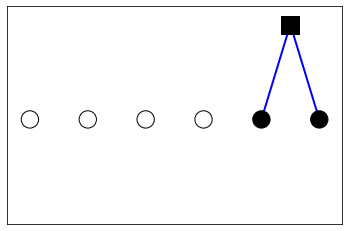

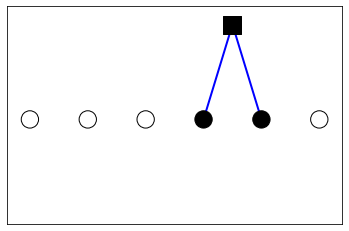

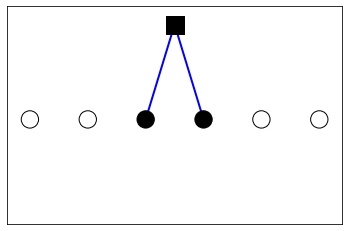

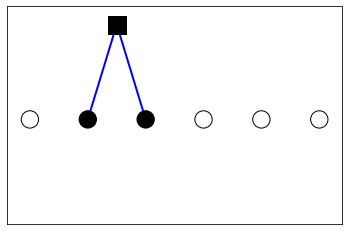

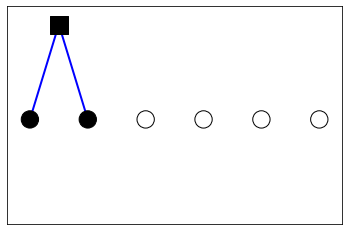

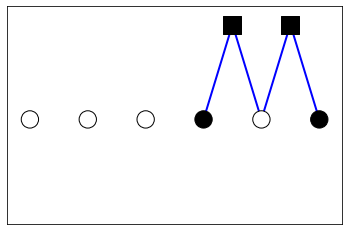

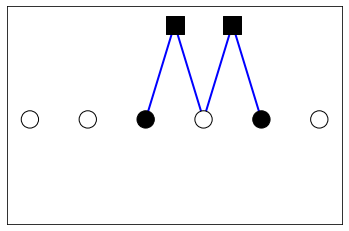

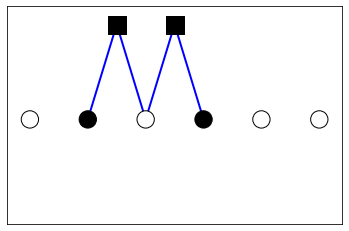

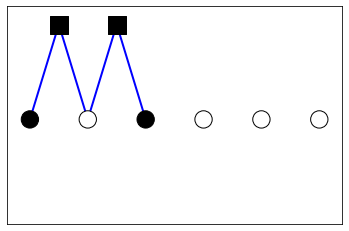

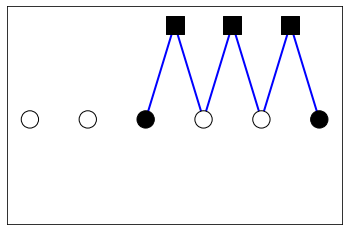

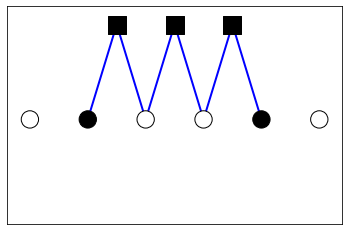

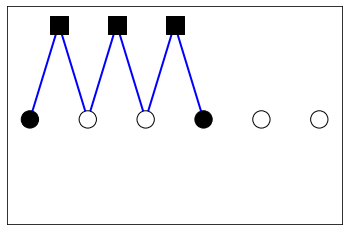

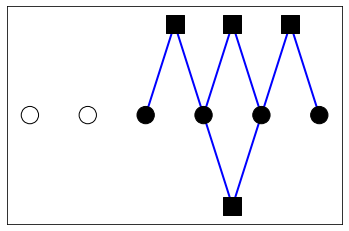

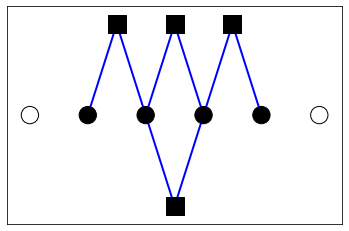

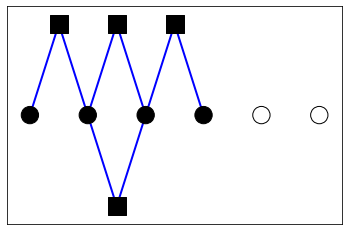

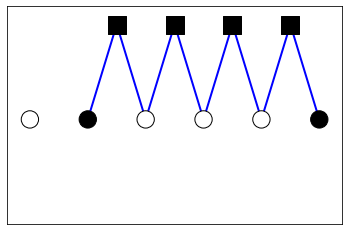

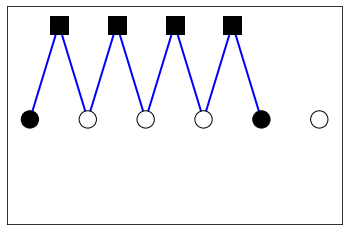

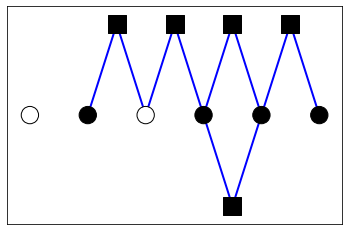

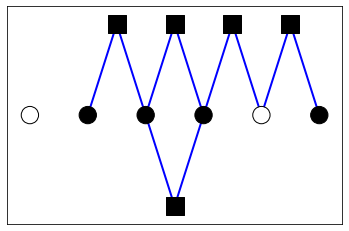

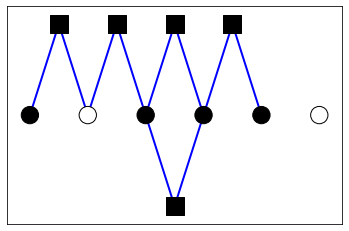

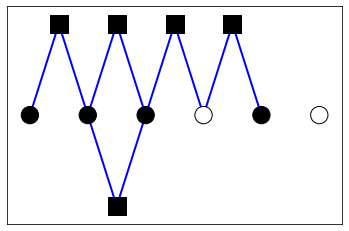

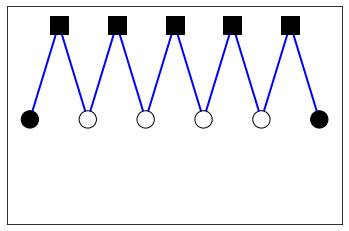

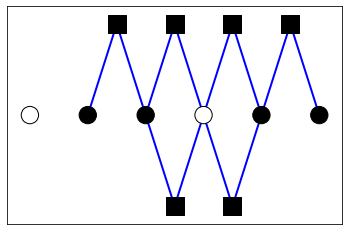

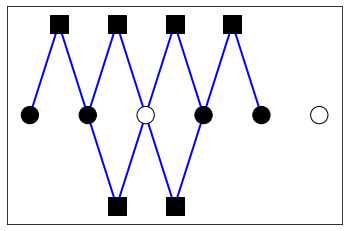

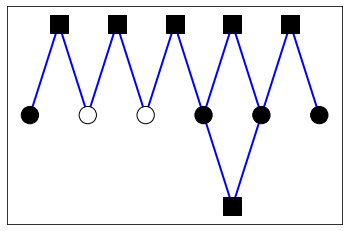

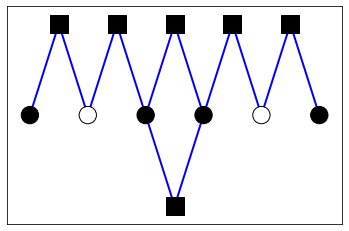

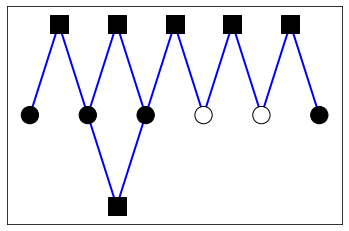

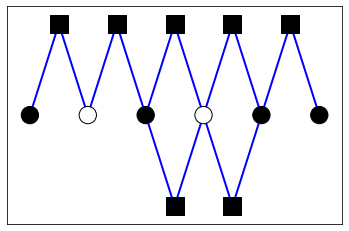

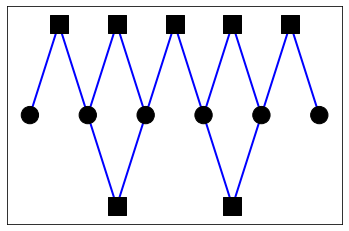

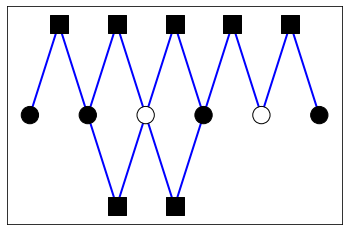

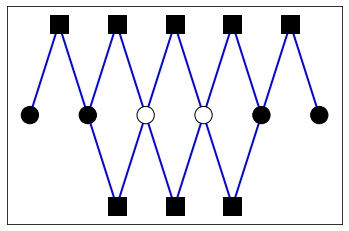

In [11]:
""""Example of graphs for given interactions

-The circles represent the qubits, black if the direction of the qubit has changed wrt to the initial state
white if unchanged.

-The squares are pictured if that interaction is activated, the lines determine to what qubits.
-A blue line represents a Pauli_X operation
-A red line represents a Pauli_Y operation
-A black line represents a Pauli_Z operation
"""""

interactions = [['X1X2',1],['X2X3',1],['X3X4',1],['X4X5',1],['X5X6',1]]
N = 6 #number of qubits
PT_order = 11 #total number of interactions one wants to consider

inter(N, interactions,PT_order).draw_diagrammatics()



In [12]:
"""Class that creates a quantum circuit for certain state according to the quantum combinatorial ansatz.
INPUT:
-N: number of qubits
-State: list or array of length N, with 1's and 0's
-a: 0 or 1; 0 for real vector, 1 for complex
-theta: the angle with which must be rotated

OUTPUT:
-cirq operations that transform vector(0) to the desired state.

"""

class QCA:
    def __init__(self,N,state,a,theta):
        self.N = N
        self.state = state
        self.a = a
        self.theta = theta
        self.qubits = [cirq.GridQubit(0, j) for j in range(N)]
        self.number_of_gates = int(np.sum(state))
    def Z_string(self):
        z=[cirq.CNOT(self.qubits[self.number_of_gates-i], self.qubits[self.number_of_gates-i-1]) for i in range(1,int(self.number_of_gates))]
        return z
    def transform_to_X(self):
        t = [cirq.H(self.qubits[i]) for i in range(int(self.number_of_gates))]
        return t

    def swap(self):
        counter = 0
        gate_pos = np.transpose(np.flip(np.argwhere(self.state == 1)))
        if self.a == 0:
            swaps = [cirq.S(self.qubits[gate_pos[0][0]])]
        else:
            swaps = []
            
        for i in range(int(self.number_of_gates)):
            if self.state[i]==0:
                swaps.append(cirq.SWAP(self.qubits[i],self.qubits[gate_pos[0][counter]]))
                counter+=1
        return swaps
    def pauli_operator(self):
        total = [self.swap()]+ [self.transform_to_X()] + [self.Z_string()]
        yield total
        yield cirq.rz(2*self.theta)(self.qubits[0])
        yield cirq.inverse(total)
                
        
        
            
    

In [13]:
"""Class that calculates the groundstate of the Hamiltionan both exact and variationally.
INPUT:
-H: Hamiltionian, (2**N X 2**N) array
-circuit: cirq.Circuit object that contains the circuit that must be variationally optimized
- P_n: number of gates in the circuit
"""
class VQA:
    def __init__(self,H,circuit, P_n):
        self.H = H
        self.circuit = circuit
        self.P_n = P_n

    def Psi(self,theta):
        resolved_circuit = cirq.resolve_parameters(circuit, self.resolver(theta))
        psi = resolved_circuit.final_wavefunction()
        while len(psi) != len(self.H[:,0]):
            psi = np.kron(psi, np.array([1,0]))
        return(psi)
    def resolver(self,theta):
        angles = {}
        for i in range(self.P_n):
            angles['theta_%s'%i] = theta[i]
        return cirq.ParamResolver(angles)
            
    def energy(self, theta):
        psi = self.Psi(theta)
        return np.transpose((np.conj(psi)).dot(self.H.dot(psi)))
    def exact(self):
        eigen = np.linalg.eigh(self.H)
        index = np.argmin(eigen[0])
        ground_energy = eigen[0][index]
        ground_state = np.round(eigen[1][:,index],3)
        return ground_state, ground_energy
    def variational(self, initial_guess = None):
        if initial_guess == None:
            initial_guess = P_n*[0]
        result = optimize.minimize(self.energy, initial_guess)
        ground_state = np.round(self.Psi(result.x),3)
        ground_energy = result.fun
        print(result.x)
        return ground_state, ground_energy
    def innerproduct(self):
        a = self.variational()[0]
        b = self.exact()[0]
        return (np.conjugate(a).dot(b))



Total Hamiltonian:
[[-4.+0.j  0.+0.j  0.+0.j  0.-1.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.-1.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -2.+0.j  0.+1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-1.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.-1.j -2.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-1.j  0.+0.j]
 [ 0.+1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-1.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j -2.+0.j  0.+0.j  0.+0.j  0.-1.j  0.-1.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+1.j  0.+0.j  0.+0.j
   0.-1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-1.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.-1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+1.j  0.+0.j 

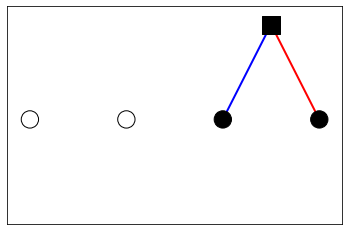

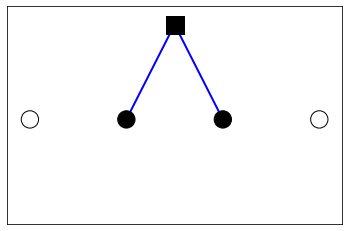

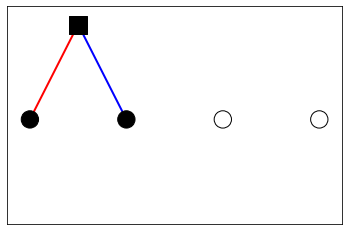

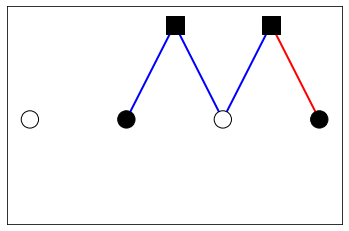

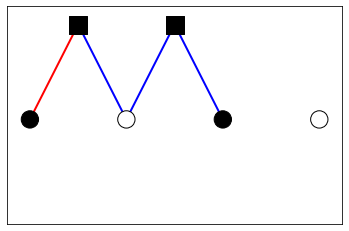

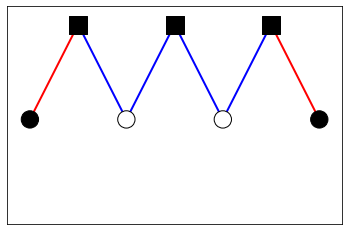

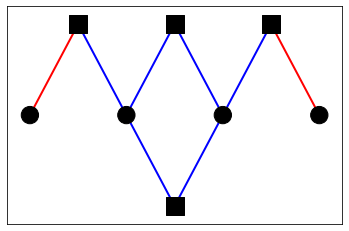


Quantum circuit that must be able to reach the groundstate:
  (0, 0)        (0, 1) (0, 2) (0, 3)
  │             │      │      │
┌╴│             │      │      │     ╶┐
│ ×─────────────┼──────┼──────×      │
│ │             ×──────×      │      │
└╴│             │      │      │     ╶┘
  │             │      │      │
  H             H      │      │
  │             │      │      │
  X─────────────@      │      │
  │             │      │      │
  Rz(2*theta_0) │      │      │
  │             │      │      │
  X─────────────@      │      │
  │             │      │      │
  H             H      │      │
  │             │      │      │
┌╴│             │      │      │     ╶┐
│ │             ×──────×      │      │
│ ×─────────────┼──────┼──────×      │
└╴│             │      │      │     ╶┘
  │             │      │      │
  │             H      S      │
  │             │      │      │
  ×─────────────┼──────×      │
  │             │      │      │
  H             │      │      │
  │           

/usr/local/lib/python3.7/site-packages/scipy/optimize/optimize.py:705: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = df
/usr/local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)


[ 0.19148033  0.30328026  0.22868932 -0.18791922 -0.05168193 -0.02307811
 -0.00703915]
Lowest eigenvalue of H calculated exact:
-4.7587704831436355

Lowest eigenvalue of H calculated variationally:
-4.758770483143659

Groundstate-vector of H calculated exact:
[-0.902+0.j     0.   -0.j     0.   +0.j    -0.   +0.225j  0.   -0.j
 -0.   -0.109j  0.235-0.j    -0.   -0.j    -0.   -0.j    -0.058+0.j
  0.   -0.109j -0.   +0.j     0.   +0.225j  0.   -0.j     0.   +0.j
  0.058-0.j   ]

Groundstate-vector of H calculated variationally:
[ 0.902+0.j    -0.   -0.j     0.   -0.j     0.   -0.225j -0.   -0.j
 -0.   +0.109j -0.235-0.j     0.   +0.j    -0.   +0.j     0.058-0.j
 -0.   +0.109j  0.   +0.j     0.   -0.225j -0.   -0.j     0.   -0.j
 -0.058+0.j   ]


In [14]:
"""Example of all elements in the code so far"""
N = 4 
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1]]
interactions = [['Y1X2',1],['X2X3',1],['X3Y4',1]]


H_0 = H_manual(N, interactions_0)
H_1 = H_manual(N, interactions)

H = H_0 + H_1

PT_order = 4
P_n = 'max'
if P_n == 'max':
    P_n = len(inter(N, interactions,PT_order).k_vecs())

print("Total Hamiltonian:")
print(H)
print()
print("All considered diagrammatics:")
inter(N, interactions,PT_order).draw_diagrammatics()
print()
print("Quantum circuit that must be able to reach the groundstate:")
inter(N,interactions,PT_order,P_n).print_circuit()


circuit = cirq.Circuit(inter(N,interactions,PT_order,P_n).build_circuit())
eigenvector_ex , eigenvalue_ex = VQA(H,circuit,P_n).exact()
eigenvector_var , eigenvalue_var = VQA(H,circuit,P_n).variational()
print('Lowest eigenvalue of H calculated exact:')
print(eigenvalue_ex)
print()
print('Lowest eigenvalue of H calculated variationally:')
print(eigenvalue_var)
print()
print('Groundstate-vector of H calculated exact:')
print(eigenvector_ex)
print()
print('Groundstate-vector of H calculated variationally:')
print(eigenvector_var)


In [26]:
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
interactions = [['X1X2',-1],['X2X3',-1],['X3X4',-1],['X4X5',-1],['X5X6',-1]]
H_0 = H_manual(N, interactions_0)
H_1 = H_manual(N, interactions)

H = H_0 + H_1

def performance(N, H, interactions, PT_order, ansatzes, max_gates, model):
    exact = exact_eigen(H)[1]
    ground_E = np.zeros((len(ansatzes), max_gates))
    Coupling = np.round(100*interactions[0][1]/(-1+interactions[0][1]),2)
    P_strings = inter(N, interactions, PT_order, max_gates).P_tensorproducts()
    for j in range(len(ansatzes)):
        label2 = ''
        if len(ansatzes[j]) == 2:
            label2 = '_%s'%ansatzes[j][1]
        if len(ansatzes[j]) == 3:
            label2 = label2 + '_%s'%ansatzes[j][2]
        my_file = "BRP_files_local/performance/"+ansatzes[j][0]+"/"+model+"_"+repr(Coupling)+"%_"+label2+"_%s"%max_gates+".csv"  
    
        if not os.path.exists(my_file):
            in_guess = np.array([])
            for i in range(1,max_gates+1):
                eigenvalue_var, in_guess = VQa(H, ansatzes[j],N, P_strings[:i], np.concatenate((in_guess, np.array([0]))))[1:3]
                ground_E[j,i-1] = (eigenvalue_var-exact)/exact
            np.savetxt(my_file, ground_E, delimiter = ',')
        else:
            print("Already stored on Computer")
            ground_E = np.array(pd.read_csv(my_file, sep=',',header=None))
        plt.plot(range(1,max_gates+1),np.real(np.log(np.real(abs(ground_E[j])))),'-o',label = "%s"%ansatzes[j][0]+label2)
    plt.title(model + " performance plot (Coupling = %s"%Coupling+'%)')
    plt.legend()
    plt.xlabel("Number of parameters (P_n)")
    plt.ylabel("$log(\epsilon)$")



Already stored on Computer
Already stored on Computer
Already stored on Computer
Already stored on Computer


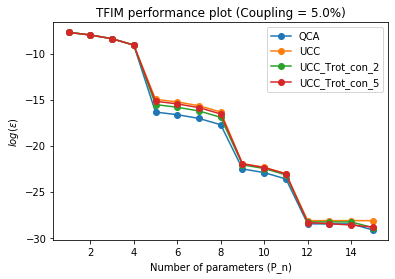

Already stored on Computer
Already stored on Computer
Already stored on Computer
Already stored on Computer


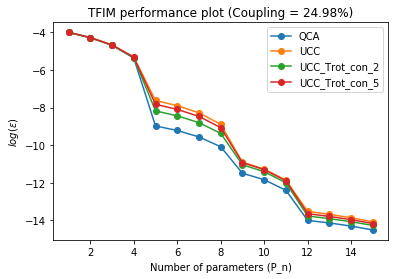

Already stored on Computer
Already stored on Computer
Already stored on Computer
Already stored on Computer


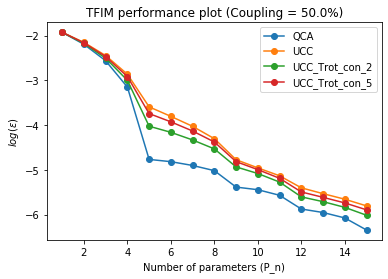

Already stored on Computer
Already stored on Computer
Already stored on Computer
Already stored on Computer


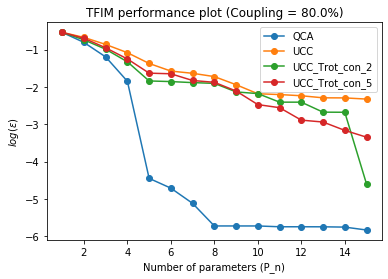

In [16]:
#TFIM for J = {5%, 25%, 50%, 80%}

Model = "TFIM"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
H_0 = H_manual(N, interactions_0)
for J in [-0.05/0.95,-0.333,-1,-4]:
    interactions = [['X1X2',J],['X2X3',J],['X3X4',J],['X4X5',J],['X5X6',J]]
    H_1 = H_manual(N, interactions)
    H = H_0 + H_1
    performance(N, H, interactions, 10, [['QCA'], ['UCC'], ['UCC_Trot_con',2],['UCC_Trot_con',5]], 15, Model)
    plt.show()




Already stored on Computer
Already stored on Computer
Already stored on Computer
Already stored on Computer


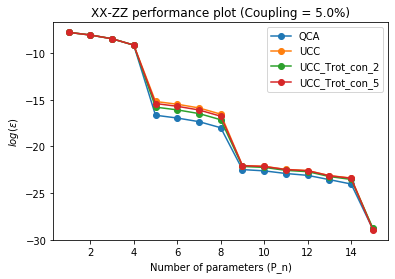

Already stored on Computer
Already stored on Computer
Already stored on Computer
Already stored on Computer


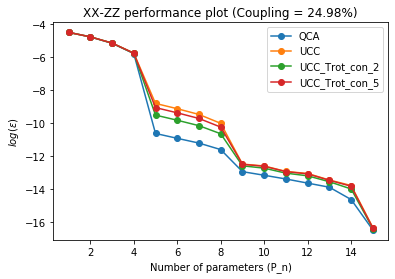

Already stored on Computer
Already stored on Computer
Already stored on Computer
Already stored on Computer


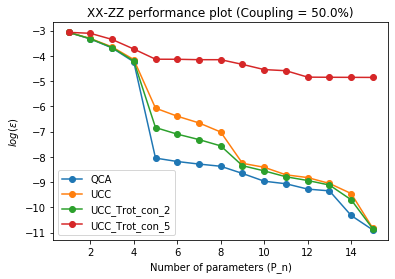

Already stored on Computer
Already stored on Computer
Already stored on Computer
Already stored on Computer


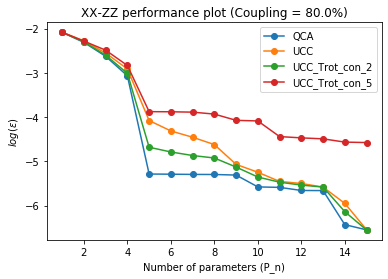

In [17]:
#Performance comparison for QCA, UCC and constrained Trotterizations with various Trotter numbers. Applied on spin 
Model = "XX-ZZ"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
H_0 = H_manual(N, interactions_0)
for J in [-0.05/0.95,-0.333,-1,-4]:
    interactions = [['X1X2',J],['X2X3',J],['X3X4',J],['X4X5',J],['X5X6',J], ['Z1Z2',J],['Z2Z3',J],['Z3Z4',J],['Z4Z5',J],['Z5Z6',J]]
    H_1 = H_manual(N, interactions)
    H = H_0 + H_1
    performance(N, H, interactions, 10, [['QCA'], ['UCC'], ['UCC_Trot_con',2],['UCC_Trot_con',5]], 15, Model)
    plt.show()

Already stored on Computer
Already stored on Computer
Already stored on Computer
Already stored on Computer


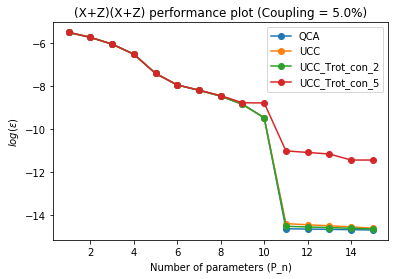

Already stored on Computer
Already stored on Computer
Already stored on Computer
Already stored on Computer


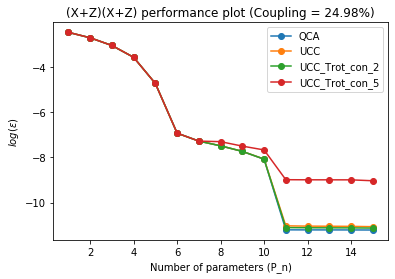

Already stored on Computer
Already stored on Computer
Already stored on Computer
Already stored on Computer


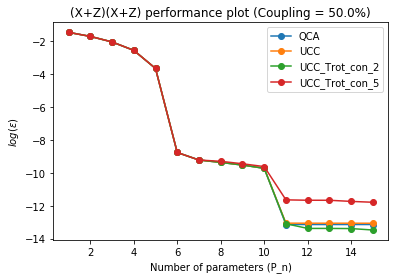

Already stored on Computer
Already stored on Computer
Already stored on Computer
Already stored on Computer


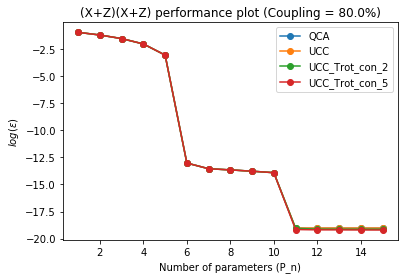

In [20]:
#Performance comparison for QCA, UCC and constrained Trotterizations with various Trotter numbers. Applied on spin 
Model = "(X+Z)(X+Z)"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
H_0 = H_manual(N, interactions_0)
for J in [-0.05/0.95,-0.333,-1,-4]:
    interactions_1 = [['X1X2',J],['X2X3',J],['X3X4',J],['X4X5',J],['X5X6',J], ['Z1Z2',J],['Z2Z3',J],['Z3Z4',J],['Z4Z5',J],['Z5Z6',J]]
    cross_terms = [['X1Z2',J], ['Z1X2',J],['X2Z3',J], ['Z2X3',J],['X3Z4',J], ['Z3X4',J], ['X4Z5',J], ['Z4X5',J],['X5Z6',J], ['Z5X6',J]]
    interactions = interactions_1 + cross_terms
    H_1 = H_manual(N, interactions)
    H = H_0 + H_1
    performance(N, H, interactions, 10, [['QCA'], ['UCC'], ['UCC_Trot_con',2],['UCC_Trot_con',5]], 15, Model)
    plt.show()

Already stored on Computer
Already stored on Computer
Already stored on Computer


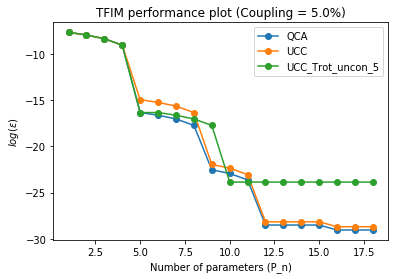

Already stored on Computer
Already stored on Computer
Already stored on Computer


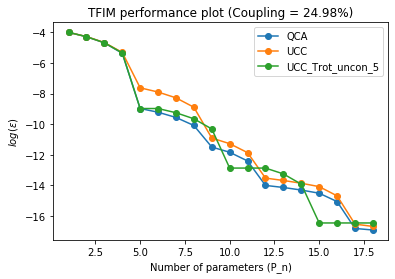

Already stored on Computer
Already stored on Computer
Already stored on Computer


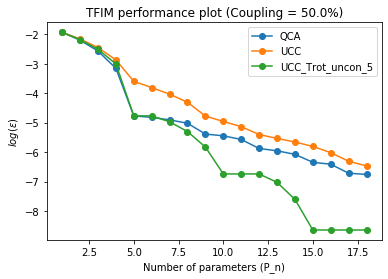

Already stored on Computer
Already stored on Computer
Already stored on Computer


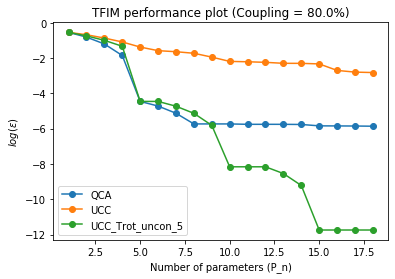

In [22]:
#Comparison Unconstrained trotterization, QCA, UCC on TFIM with N = 6

Model = "TFIM"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
H_0 = H_manual(N, interactions_0)
PT_order = 18
max_gates = 18
for J in [-0.05/0.95,-0.333,-1,-4]:
    interactions = [['X1X2',J],['X2X3',J],['X3X4',J],['X4X5',J],['X5X6',J]]
    H_1 = H_manual(N, interactions)
    H = H_0 + H_1
    performance(N, H, interactions, 10, [['QCA'],['UCC'],['UCC_Trot_uncon',5]], max_gates, Model)
    plt.show()

Already stored on Computer
Already stored on Computer
Already stored on Computer


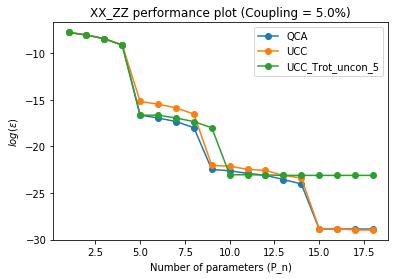

Already stored on Computer
Already stored on Computer
Already stored on Computer


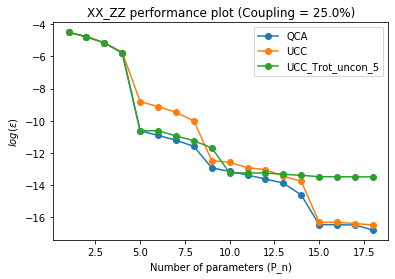

Already stored on Computer
Already stored on Computer
Already stored on Computer


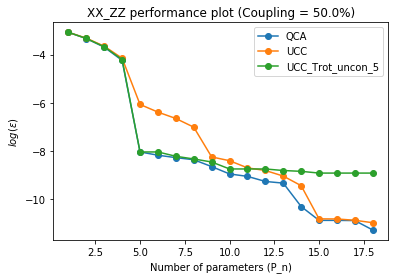

Already stored on Computer
Already stored on Computer
Already stored on Computer


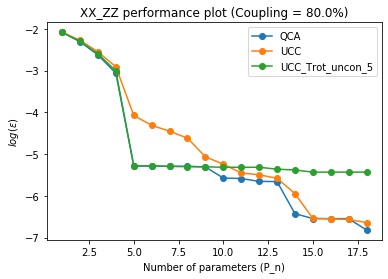

In [23]:
#Comparison Unconstrained trotterization, QCA, UCC on XX_ZZ with N = 6

Model = "XX_ZZ"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
H_0 = H_manual(N, interactions_0)
PT_order = 18
max_gates = int(np.round(len(inter(N, interactions,PT_order).k_vecs())/4,0))
max_gates = 18
for J in [-0.05/0.95,-0.3333333,-1,-4]:
    interactions = [['X1X2',J],['X2X3',J],['X3X4',J],['X4X5',J],['X5X6',J],['Z1Z2',J],['Z2Z3',J],['Z3Z4',J],['Z4Z5',J],['Z5Z6',J]]
    H_1 = H_manual(N, interactions)
    H = H_0 + H_1
    performance(N, H, interactions, 10, [['QCA'],['UCC'],['UCC_Trot_uncon',5]], max_gates, Model)
    plt.show()

Already stored on Computer
Already stored on Computer


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


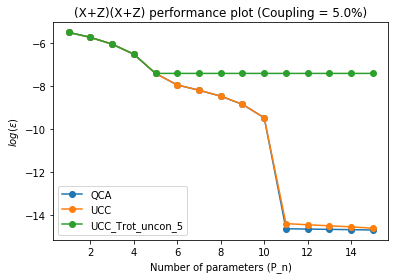

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


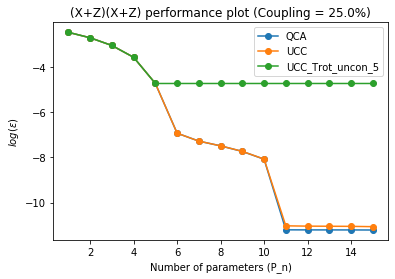

Already stored on Computer
Already stored on Computer


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


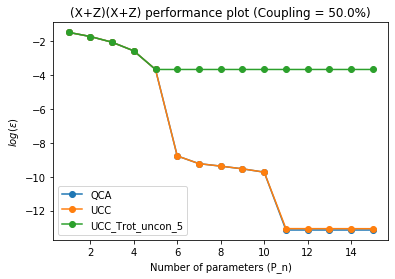

Already stored on Computer
Already stored on Computer
Already stored on Computer


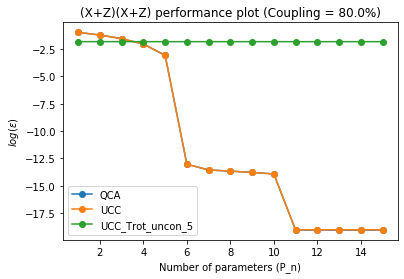

In [28]:

Model = "(X+Z)(X+Z)"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
H_0 = H_manual(N, interactions_0)
PT_order = 18
max_gates = 15
for J in [-0.05/0.95,-0.3333333,-1,-4]:
    interactions_1 = [['X1X2',J], ['X2X3', J], ['X3X4',J], ['X4X5',J], ['X5X6',J],['Z1Z2',J], ['Z2Z3', J], ['Z3Z4',J], ['Z4Z5',J], ['Z5Z6',J]]
    cross_terms = [['X1Z2',J], ['Z1X2',J],['X2Z3',J], ['Z2X3',J],['X3Z4',J], ['Z3X4',J], ['X4Z5',J], ['Z4X5',J],['X5Z6',J], ['Z5X6',J]]
    interactions = interactions_1 + cross_terms
    H_1 = H_manual(N, interactions)
    H = H_0 + H_1
    performance(N, H, interactions, 10, [['QCA'],['UCC'],['UCC_Trot_uncon',5]], max_gates, Model)
    plt.show()

Already stored on Computer
Already stored on Computer
Already stored on Computer


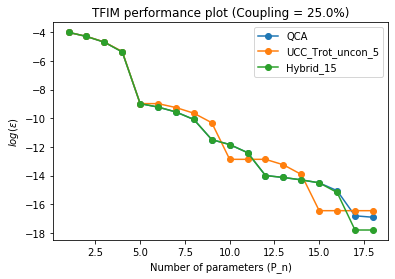

Already stored on Computer
Already stored on Computer
Already stored on Computer


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log


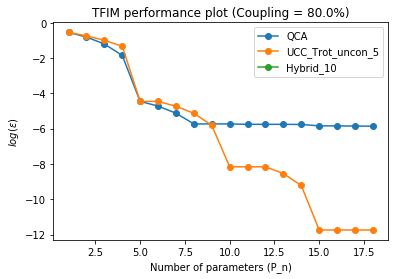

In [143]:
#Comparison Unconstrained trotterization, QCA, UCC on TFIM with N = 6

Model = "TFIM"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
H_0 = H_manual(N, interactions_0)
PT_order = 11
max_gates = 18
z = 15
for J in [-0.33333, -4]:
    interactions = [['X1X2',J],['X2X3',J],['X3X4',J],['X4X5',J],['X5X6',J]]
    H_1 = H_manual(N, interactions)
    H = H_0 + H_1
    performance(N, H, interactions, 10, [['QCA'],['UCC_Trot_uncon', 5],['Hybrid', 5, z]], max_gates, Model)
    plt.show()
    z = 10

Already stored on Computer
Already stored on Computer
Already stored on Computer


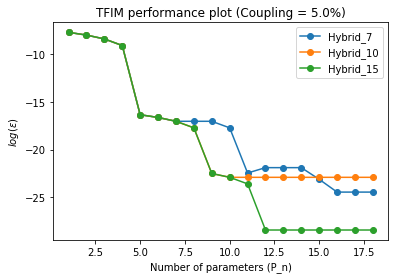

Already stored on Computer
Already stored on Computer
Already stored on Computer


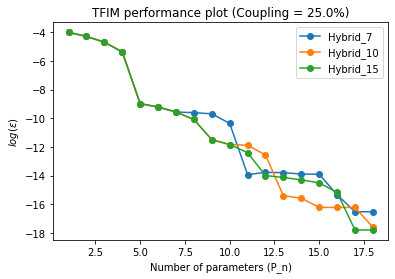

Already stored on Computer
Already stored on Computer
Already stored on Computer


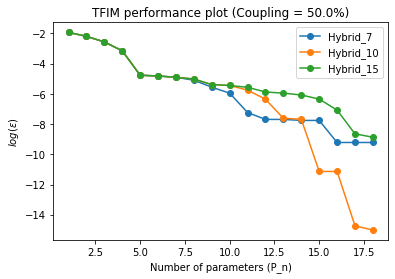

Already stored on Computer
Already stored on Computer
Already stored on Computer


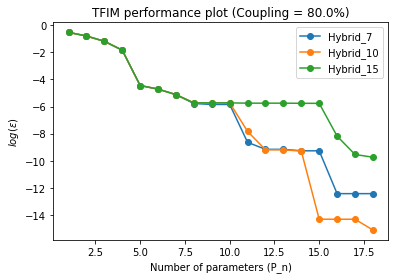

In [148]:
#Comparison Unconstrained trotterization, QCA, UCC on TFIM with N = 6

Model = "TFIM"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
H_0 = H_manual(N, interactions_0)
PT_order = 11
max_gates = 18
for J in [-0.05/0.95, -0.33333, -1, -4]:
    interactions = [['X1X2',J],['X2X3',J],['X3X4',J],['X4X5',J],['X5X6',J]]
    H_1 = H_manual(N, interactions)
    H = H_0 + H_1
    performance(N, H, interactions, 10, [['Hybrid',5,7],['Hybrid', 5,10],['Hybrid', 5, 15]], max_gates, Model)
    plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


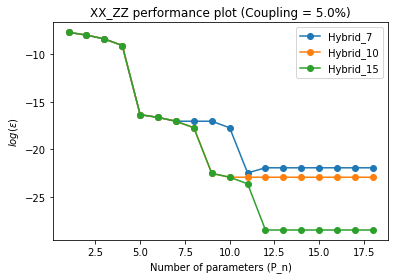

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


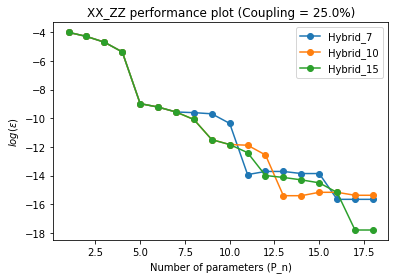

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


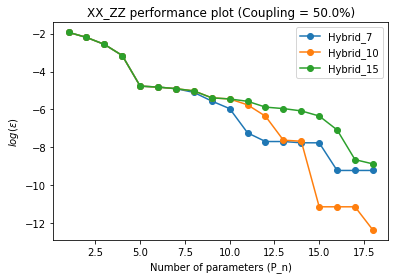

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


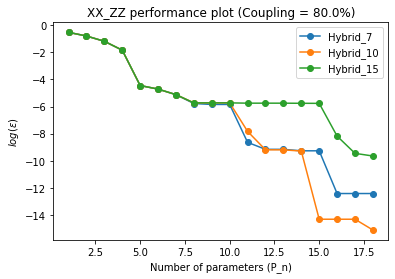

In [130]:
Model = "XX_ZZ"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
H_0 = H_manual(N, interactions_0)
PT_order = 11
max_gates = 18
for J in [-0.05/0.95, -0.33333, -1, -4]:
    interactions = [['X1X2',J],['X2X3',J],['X3X4',J],['X4X5',J],['X5X6',J]]
    H_1 = H_manual(N, interactions)
    H = H_0 + H_1
    performance(N, H, interactions, 10, [['Hybrid',5,7],['Hybrid', 5,10],['Hybrid', 5, 15]], max_gates, Model)
    plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


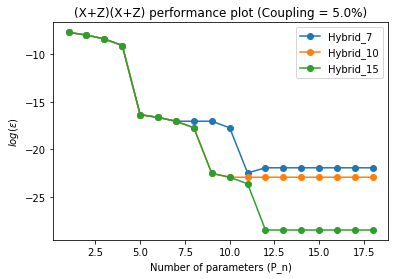

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


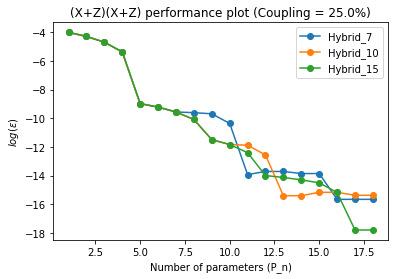

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


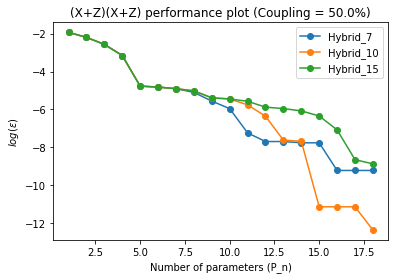

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


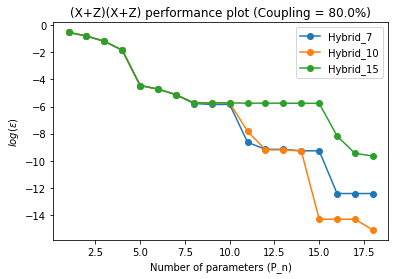

In [131]:
Model = "(X+Z)(X+Z)"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
H_0 = H_manual(N, interactions_0)
PT_order = 11
max_gates = 18
z = 14
for J in [-0.05/0.95, -0.33333, -1, -4]:
    interactions = [['X1X2',J],['X2X3',J],['X3X4',J],['X4X5',J],['X5X6',J]]
    H_1 = H_manual(N, interactions)
    H = H_0 + H_1
    performance(N, H, interactions, 10, [['Hybrid',5,7],['Hybrid', 5,10],['Hybrid', 5, 15]], max_gates, Model)
    plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(y

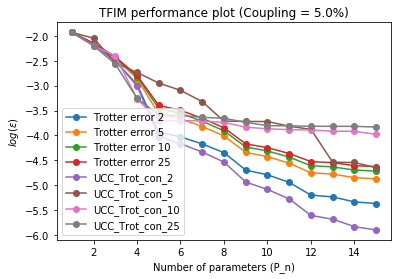

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/pytho

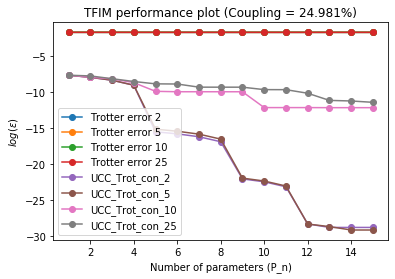

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/pytho

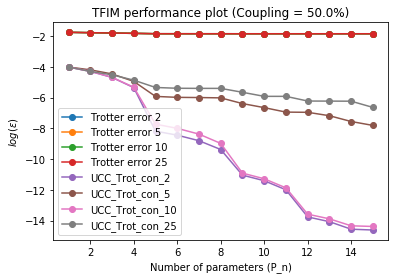

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/pytho

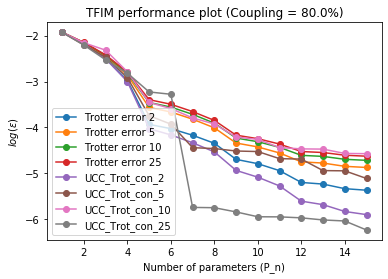

In [138]:
#TFIM for J = {5%, 25%, 50%, 80%}

Model = "TFIM"
N = 6

exact = exact_eigen(H)[1]
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
interactions = [['X1X2',-1],['X2X3',-1],['X3X4',-1],['X4X5',-1],['X5X6',-1]]
H_0 = H_manual(N, interactions_0)
max_gates = 15
PT_order = 11
P_strings = inter(N, interactions, PT_order, max_gates).P_tensorproducts()
for J in [-0.05/0.95,-0.333,-1,-4]:
    H_1 = H_manual(N, interactions)
    H = H_0 + H_1
    E_trot_err_2 = (np.array([Trot_error(H, N, P_strings[:i],2) for i in range(1,max_gates+1)])-exact)/exact
    E_trot_err_5 = (np.array([Trot_error(H, N, P_strings[:i],5) for i in range(1,max_gates+1)])-exact)/exact
    E_trot_err_10 = (np.array([Trot_error(H, N, P_strings[:i],10) for i in range(1,max_gates+1)])-exact)/exact
    E_trot_err_25 = (np.array([Trot_error(H, N, P_strings[:i],25) for i in range(1,max_gates+1)])-exact)/exact
    
    interactions = [['X1X2',J],['X2X3',J],['X3X4',J],['X4X5',J],['X5X6',J]]
    plt.plot(range(1,max_gates+1), np.log(np.abs(E_trot_err_2)),'-o', label = "Trotter error 2")
    plt.plot(range(1,max_gates+1), np.log(np.abs(E_trot_err_5)),'-o', label = "Trotter error 5")
    plt.plot(range(1,max_gates+1), np.log(np.abs(E_trot_err_10)),'-o', label = "Trotter error 10")
    plt.plot(range(1,max_gates+1), np.log(np.abs(E_trot_err_25)),'-o', label = "Trotter error 25")
    performance(N, H, interactions, 10, [['UCC_Trot_con',2],['UCC_Trot_con',5],['UCC_Trot_con',10],['UCC_Trot_con',25]], max_gates, Model)
    plt.show()


/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


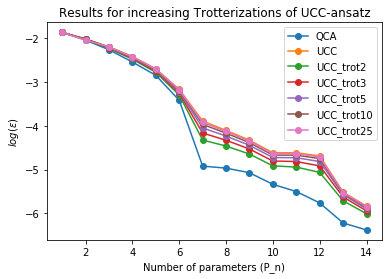

In [18]:
plt.plot(range(1,max_gates),np.log(ground_QCA),'-o',label = "QCA")
plt.plot(range(1,max_gates),np.log(ground_UCC), '-o',label = "UCC")
plt.plot(range(1,max_gates),np.log(ground_UCC_trot), '-o',label = "UCC_trot2")
plt.plot(range(1,max_gates),np.log(abs(ground_UCC_trot3)), '-o',label = "UCC_trot3" )
plt.plot(range(1,max_gates),np.log(abs(ground_UCC_trot5)), '-o',label = "UCC_trot5")
plt.plot(range(1,max_gates),np.log(abs(ground_UCC_trot10)),'-o', label = "UCC_trot10")
plt.plot(range(1,max_gates),np.log(abs(ground_UCC_trot25)),'-o', label = "UCC_trot25")
plt.xlabel("Number of parameters (P_n)")
plt.ylabel("$log(\epsilon)$")
plt.title("Results for increasing Trotterizations of UCC-ansatz")
plt.legend()
plt.savefig("Trotter_steps")
plt.show()

$\textbf{Pattern in graph}$

In the graph above, one can see the ground-state energy estimations aproach the actual ground-state energy with steps as more gates are added. From the $6^{th}$ to the $7^{th}$ value of P_n, there is a little drop in the graph. This can be explained as follows: Since the system has 8 qubits and 7 first-order interactions, the ground-state up to the first order in perturbation theory can be reached with the help of 7 gates/parameters. But with anything less than 7 gates, there is no guarentee that the first-order ground state can be reached. The $8^{th}$ gate will give a contribution of second order to the ground state, and thus will give relatively less improvement compared to the gates corresponding to a first-order contribution.

$\textbf{Comparison ansatzes}$

One can see that the QCA ansatz appears to work the best of all ansatzes. The bigger the Trotter number, the less accurate the calculated ground state energy. As the Trotter number gets bigger, the performance approaches the un-Trotterized UCC ansatz.


[-8.236067977499648]
[-8.236067977499648, -8.484435331765848]
[-8.236067977499648, -8.484435331765848, -8.734230848278926]


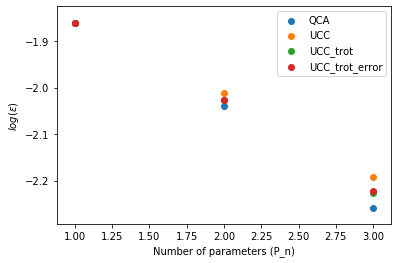

In [146]:
N = 8
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1],['Z7',-1],['Z8',-1]]
interactions = [['Y1X2',1],['X2X3',1],['X3Y4',1],['X4X5',1],['X5X6',1],['X6X7',1],['X7X8',1]]

H_0 = H_manual(N,interactions_0)
H_1 = H_manual(N,interactions)
H = H_0 + H_1

PT_order = 4
P_n = 'max'
if P_n == 'max':
    P_n = len(inter(N, interactions,PT_order).k_vecs())

exact = exact_eigen(H)[1]
ground_QCA = []
ground_UCC = []
ground_UCC_trot = []
ground_UCC_trot_err = []
max_gates = 4
P_strings = inter(N, interactions, PT_order, P_n).P_tensorproducts()
in_guess = np.array([])
for i in range(1,max_gates):
    eigenvalue_var, in_guess = VQa(H, ['QCA'],N, P_strings[:i], np.concatenate((in_guess, np.array([0]))))[1:3]
    eigenvalue_var_ucc = VQa(H, ['UCC'], N, P_strings[:i], in_guess)[1]
    eigenvalue_var_ucc_Trot = VQa(H, ['UCC_Trot_con',2], N, P_strings[:i], in_guess)[1]
    eigenvalue_var_ucc_Trot_err = Trot_error(H, N, P_strings[:i], 2)
    ground_QCA.append(eigenvalue_var)
    ground_UCC.append(eigenvalue_var_ucc)
    ground_UCC_trot.append(eigenvalue_var_ucc_Trot)
    ground_UCC_trot_err.append(eigenvalue_var_ucc_Trot_err)

    print(ground_QCA)

ground_QCA = (np.array(ground_QCA)-exact)/exact
ground_UCC = (np.array(ground_UCC)-exact)/exact
ground_UCC_trot = (np.array(ground_UCC_trot)-exact)/exact 
ground_UCC_trot_err = (np.array(ground_UCC_trot_err)-exact)/exact
plt.scatter(range(1,max_gates),np.log(abs(ground_QCA)),label = "QCA")
plt.scatter(range(1,max_gates),np.log(abs(ground_UCC)),label = "UCC")
plt.scatter(range(1,max_gates),np.log(abs(ground_UCC_trot)),label = "UCC_trot")
plt.scatter(range(1,max_gates),np.log(abs(ground_UCC_trot_err)),label = "UCC_trot_error")

plt.legend()
plt.xlabel("Number of parameters (P_n)")
plt.ylabel("$log(\epsilon)$")
plt.show()


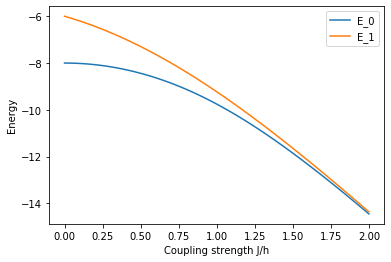

In [83]:
a = []
b = []
N = 8
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1],['Z7',-1],['Z8',-1]]

for i in np.linspace(0,2,100):
    interactions = [['Y1X2',i],['X2X3',i],['X3Y4',i],['X4X5',i],['X5X6',i],['X6X7',i],['X7X8',i]]
    H_0 = H_manual(N, interactions_0)
    H_1 = H_manual(N, interactions)
    H = H_0 + H_1
    exact_0 = np.linalg.eigh(H)[0][0]
    exact_1 = np.linalg.eigh(H)[0][1]
    
    a.append(exact_0)
    b.append(exact_1)
plt.plot(np.linspace(0,2,100),a,label = "E_0")
plt.plot(np.linspace(0,2,100),b, label = "E_1")
plt.legend()
plt.xlabel("Coupling strength J/h")
plt.ylabel("Energy")
plt.show()


In [128]:
def angles(N, H , ansatz, P_strings, max_gates, model):
    angless = np.zeros((max_gates, max_gates))
    name = ""
    if len(ansatz) == 2:
        name = "_%s"%ansatz[1]
    if len(ansatz) == 3:
        name = name + "_%s"%ansatz[2]
    my_file = "BRP_files_local/angles/"+ansatz[0]+"/"+model+name+"_%s"%max_gates+".csv"  
    
    if not os.path.exists(my_file):
    
        for i in range(1,max_gates+1):
            a = (VQa(H, ansatz,N, P_strings[:i])[2]%(2*np.pi))
            a = np.where(a > np.pi, a-2*np.pi, a)
            angless[i-1,:i] = a
        np.savetxt(my_file, angless, delimiter=",")
    else:
        print("Already stored on Computer")
        angless = np.array(pd.read_csv(my_file, sep=',',header=None))
    
    for i in range(max_gates):
        plt.plot((np.array(list(range(1,max_gates+1)))),(angless[:,i]),'-o', label = "gate %s"%(i+1))
    plt.legend(bbox_to_anchor=(1,1))
    plt.title(ansatz[0]+name)
    plt.xlabel('Number of gates')
    plt.ylabel('$\theta in radians$')

    return angless


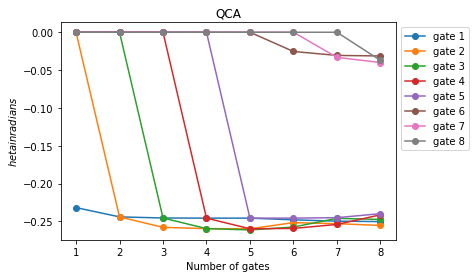

In [34]:
N = 6
model = "TFIM_50%"
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
interactions = [['X1X2',-1],['X2X3',-1],['X3X4',-1],['X4X5',-1],['X5X6',-1]]
H_0 = H_manual(N, interactions_0)
H_1 = H_manual(N, interactions)

H = H_0 + H_1
P_strings = inter(N, interactions,11,11).P_tensorproducts()
angles(N, H, ['QCA'], P_strings, 8, model)
plt.show()

array([[-1.02745263,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.77871293, -0.77871263,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.19807804, -0.14180995, -0.19807807,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.14707115, -0.17004026, -0.17004019, -0.14707108,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.29332855, -0.35012263, -0.3253732 , -0.16919216, -0.21901056,
         0.        ,  0.        ,  0.        ],
       [-0.02526999, -0.00681821, -0.01308878, -0.01502523, -0.01843573,
        -0.01639951,  0.        ,  0.        ],
       [-0.2460281 , -0.02632789,  0.14899544,  0.11201143,  0.59615197,
         0.17664251, -0.12739841,  0.        ],
       [ 0.3153125 ,  0.1417042 ,  0.19519208, -0.10614959, -0.514773  ,
         0.14834575, -0.05030887, -0.04490193]])

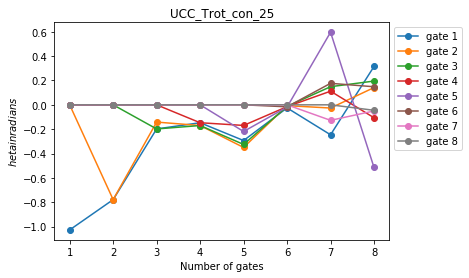

In [35]:
model = "TFIM_80%"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
interactions = [['X1X2',-4],['X2X3',-4],['X3X4',-4],['X4X5',-4],['X5X6',-4]]
H_0 = H_manual(N, interactions_0)
H_1 = H_manual(N, interactions)

H = H_0 + H_1
P_strings = inter(N, interactions,11,8).P_tensorproducts()
angles(N, H, ['UCC_Trot_con',25], P_strings, 8, model)

Already stored on Computer


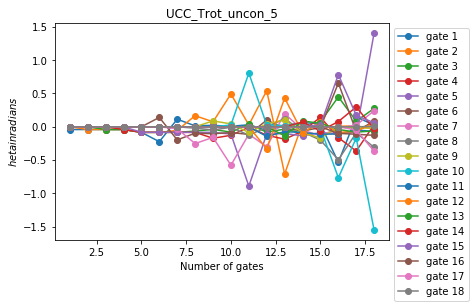

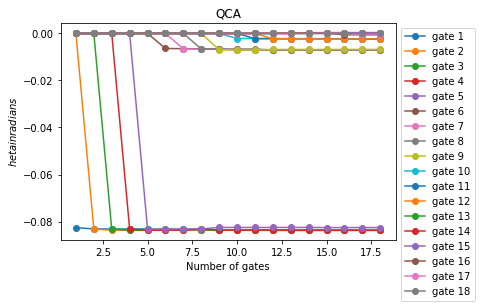

In [36]:
#25% coupling
model = "TFIM_25%"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
interactions = [['X1X2',-0.33333],['X2X3',-0.333333],['X3X4',-0.3333333],['X4X5',-0.333333],['X5X6',-0.3333333]]
H_0 = H_manual(N, interactions_0)
H_1 = H_manual(N, interactions)
H = H_0 + H_1
P_strings = inter(N, interactions,11,18).P_tensorproducts()
angles(N, H, ['UCC_Trot_uncon',5], P_strings, 18, model)
plt.show()
angles(N, H, ['QCA'],P_strings,18, model)
plt.show()

Already stored on Computer


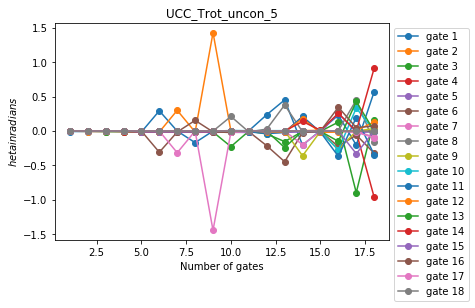

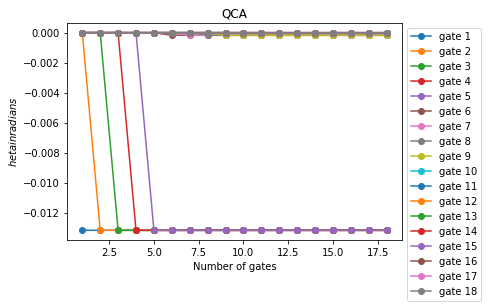

In [37]:
#5% coupling
model = "TFIM_5%"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
interactions = [['X1X2',-0.05/0.95],['X2X3',-0.05/0.95],['X3X4',-0.05/0.95],['X4X5',-0.05/0.95],['X5X6',-0.05/0.95]]
H_0 = H_manual(N, interactions_0)
H_1 = H_manual(N, interactions)
H = H_0 + H_1
P_strings = inter(N, interactions,11,18).P_tensorproducts()
angles(N, H, ['UCC_Trot_uncon',5], P_strings, 18, model)
plt.show()
angles(N, H, ['QCA'],P_strings,18, model)
plt.show()

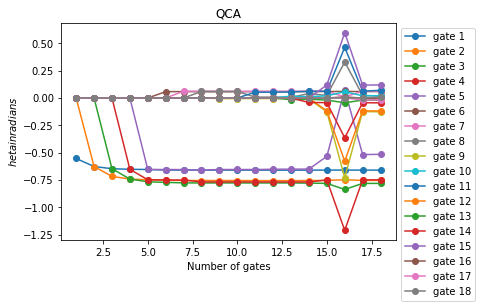

In [75]:
model = "TFIM_80%"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
interactions = [['X1X2',-4],['X2X3',-4],['X3X4',-4],['X4X5',-4],['X5X6',-4]]
H_0 = H_manual(N, interactions_0)
H_1 = H_manual(N, interactions)
H = H_0 + H_1
P_strings = inter(N, interactions,11,18).P_tensorproducts()
angles(N, H, ['QCA'],P_strings,18, model)
plt.show()

Already stored on Computer


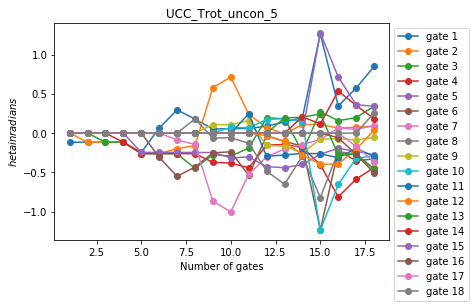

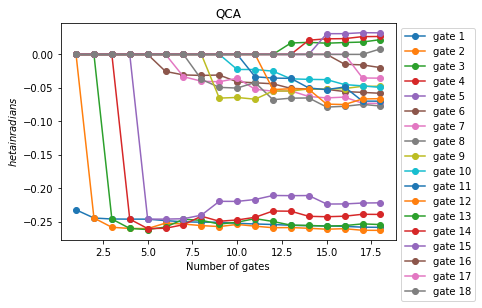

In [38]:
model = "TFIM_50%"

N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
interactions = [['X1X2',-1],['X2X3',-1],['X3X4',-1],['X4X5',-1],['X5X6',-1]]
H_0 = H_manual(N, interactions_0)
H_1 = H_manual(N, interactions)
H = H_0 + H_1
P_strings = inter(N, interactions,11,18).P_tensorproducts()
angles(N, H, ['UCC_Trot_uncon',5], P_strings, 18, model)
plt.show()
angles(N, H, ['QCA'],P_strings,18, model)
plt.show()

Already stored on Computer


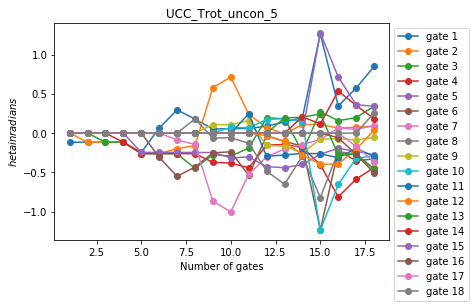

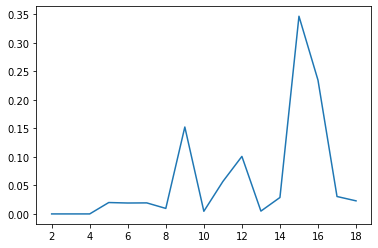

In [39]:
#niter = 5
model = "TFIM_50%"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
interactions = [['X1X2',-1],['X2X3',-1],['X3X4',-1],['X4X5',-1],['X5X6',-1]]
H_0 = H_manual(N, interactions_0)
H_1 = H_manual(N, interactions)
H = H_0 + H_1
P_strings = inter(N, interactions,11,18).P_tensorproducts()
a= angles(N, H, ['UCC_Trot_uncon',5], P_strings, 18, model)
plt.show()
#b = angles(N, H, ['QCA'],P_strings,10)
#plt.show()

#a = np.exp(1j*a)
#b = np.exp(1j*b)
max_gates = 18
k = np.array([])
for i in range(max_gates-1):
    u = a[i,:i+1]-a[i+1, :i+1]
    z = np.vdot(u,u)/(i+1)
    k =np.append(k,z)
#print(np.exp(1j*k))
plt.plot(np.array(list(range(2,max_gates+1))),k)#np.real(np.exp(1j*k)-1))
plt.show()




/usr/local/lib/python3.7/site-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


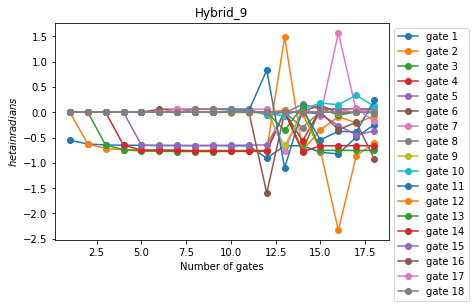

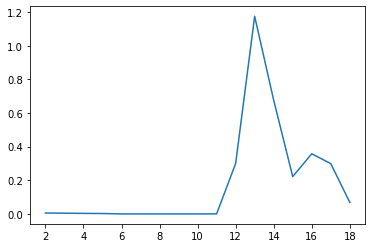

In [40]:
#Angles for the hybrid ansatz, for coupling of 50%
model = "TFIM_80%"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
interactions = [['X1X2',-4],['X2X3',-4],['X3X4',-4],['X4X5',-4],['X5X6',-4]]
H_0 = H_manual(N, interactions_0)
H_1 = H_manual(N, interactions)
H = H_0 + H_1
P_strings = inter(N, interactions,11,18).P_tensorproducts()
a= angles(N, H, ['Hybrid', 5, 9], P_strings, 18, model)
plt.show()
#b = angles(N, H, ['QCA'],P_strings,10)
#plt.show()

#a = np.exp(1j*a)
#b = np.exp(1j*b)
max_gates = 18
k = np.array([])
for i in range(max_gates-1):
    u = a[i,:i+1]-a[i+1, :i+1]
    z = np.vdot(u,u)/(i+1)
    k =np.append(k,z)
#print(np.exp(1j*k))
plt.plot(np.array(list(range(2,max_gates+1))),k)#np.real(np.exp(1j*k)-1))
plt.show()



Already stored on Computer


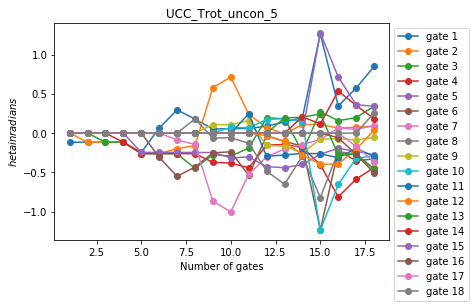

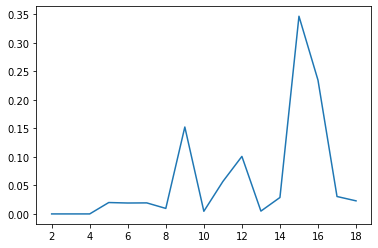

[-0.11591191 -0.23141759 -0.34679744 -0.46217524 -1.27241441 -1.2724144
 -1.30806588 -1.33478379 -1.33426575 -1.33826974 -1.35498104 -1.36028906
 -1.39853854 -1.34832817 -1.48895355 -1.3500827  -1.34124582 -1.28787828]


In [41]:

model = "TFIM_50%"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
interactions = [['X1X2',-1],['X2X3',-1],['X3X4',-1],['X4X5',-1],['X5X6',-1]]
H_0 = H_manual(N, interactions_0)
H_1 = H_manual(N, interactions)
H = H_0 + H_1
P_strings = inter(N, interactions,11,18).P_tensorproducts()
a= angles(N, H, ['UCC_Trot_uncon',5], P_strings, 18, model)
plt.show()
#b = angles(N, H, ['QCA'],P_strings,10)
#plt.show()

#a = np.exp(1j*a)
#b = np.exp(1j*b)
max_gates = 18
k = np.array([])
for i in range(max_gates-1):
    u = a[i,:i+1]-a[i+1, :i+1]
    z = np.vdot(u,u)/(i+1)
    k =np.append(k,z)
#print(np.exp(1j*k))
plt.plot(np.array(list(range(2,max_gates+1))),k)#np.real(np.exp(1j*k)-1))
plt.show()
h = np.sum(a, axis = 1)
print(h)

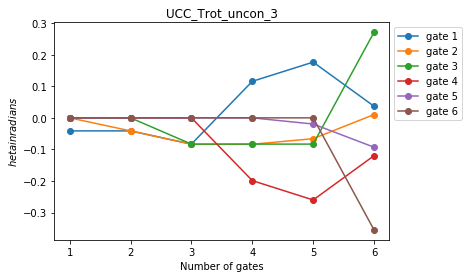

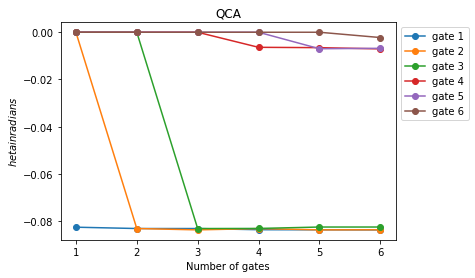

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


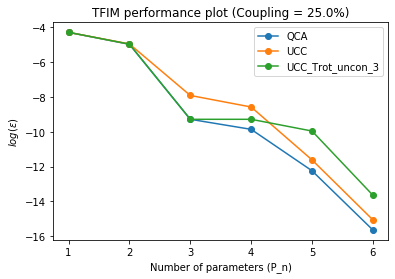

In [42]:
N= 4
model = "TFIM_25%"
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1]]
interactions = [['X1X2',-.333333],['X2X3',-.333333],['X3X4',-.3333333]]
H_0 = H_manual(N, interactions_0)
H_1 = H_manual(N, interactions)
H = H_0 + H_1
P_strings = inter(N, interactions,6,6).P_tensorproducts()

a= angles(N, H, ['UCC_Trot_uncon',3], P_strings, 6, model)
plt.show()

b = angles(N, H, ['QCA'], P_strings, 6, model)
plt.show()
Model = "TFIM"
performance(N, H, interactions, 10, [['QCA'],['UCC'],['UCC_Trot_uncon',3]], 6, Model)
plt.show()

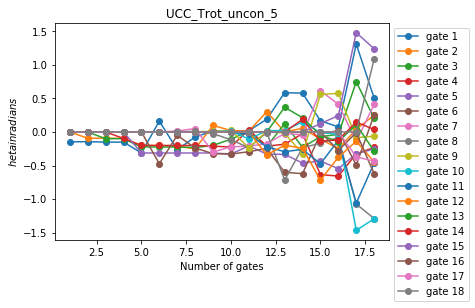

In [43]:
#Comparison Unconstrained trotterization, QCA, UCC on XX_ZZ with N = 6

Model = "XX_ZZ_80%"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
H_0 = H_manual(N, interactions_0)
PT_order = 11
max_gates = 18
for J in [-4]:
    interactions = [['X1X2',J],['X2X3',J],['X3X4',J],['X4X5',J],['X5X6',J],['Z1Z2',J],['Z2Z3',J],['Z3Z4',J],['Z4Z5',J],['Z5Z6',J]]
    H_1 = H_manual(N, interactions)
    H = H_0 + H_1
    P_strings = inter(N, interactions,11,18).P_tensorproducts()
    angles(N, H,['UCC_Trot_uncon',5], P_strings, max_gates, Model)
    plt.show()

Already stored on Computer


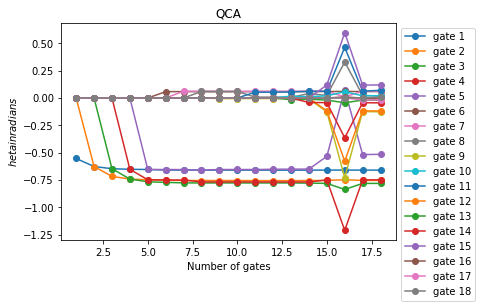

In [129]:
#80% coupling
model = "TFIM_80%"
N = 6
J = -4
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
interactions = [['X1X2',J],['X2X3',J],['X3X4',J],['X4X5',J],['X5X6',J]]
H_0 = H_manual(N, interactions_0)
H_1 = H_manual(N, interactions)
H = H_0 + H_1
max_gates = 20
P_strings = inter(N, interactions,11,18).P_tensorproducts()
angles(N, H, ['QCA'], P_strings, 18, model)
plt.show()



In [46]:
import pandas as pd 
np_array = np.array([[1,2,3],[4,5,6]])
np.savetxt("test2.csv", np_array, delimiter=",")

In [51]:
interactions_1 = [['X1X2',J],['X2X3',J],['X3X4',J],['X4X5',J],['X5X6',J], ['Z1Z2',J],['Z2Z3',J],['Z3Z4',J],['Z4Z5',J],['Z5Z6',J]]
cross_terms = [['X1Z2',J], ['Z1X2',J],['X2Z3',J], ['Z2X3',J],['X3Z4',J], ['Z3X4',J], ['X4Z5',J], ['Z4X5',J],['X5Z6',J], ['Z5X6',J]]
interactions = interactions_1 + cross_terms
print(interactions)

[['X1X2', -4], ['X2X3', -4], ['X3X4', -4], ['X4X5', -4], ['X5X6', -4], ['Z1Z2', -4], ['Z2Z3', -4], ['Z3Z4', -4], ['Z4Z5', -4], ['Z5Z6', -4], ['X1Z2', -4], ['Z1X2', -4], ['X2Z3', -4], ['Z2X3', -4], ['X3Z4', -4], ['Z3X4', -4], ['X4Z5', -4], ['Z4X5', -4], ['X5Z6', -4], ['Z5X6', -4]]


In [93]:


def hessian(N, H , ansatz, P_strings, max_gates, model):
    angless = np.zeros((max_gates, max_gates))
    name = ""
    if len(ansatz) == 2:
        name = "_%s"%ansatz[1]
    if len(ansatz) == 3:
        name = name + "_%s"%ansatz[2]
    my_file = "BRP_files_local/hessian/"+ansatz[0]+"/"+model+name+"_%s"%max_gates+".csv"  
    
    if not os.path.exists(my_file):
    
        for i in range(1,max_gates+1):
            a = VQa(H, ansatz,N, P_strings[:i])[3]
            print(a) 
        #np.savetxt(my_file, angless, delimiter=",")
    else:
        print("Already stored on Computer")
        angless = np.array(pd.read_csv(my_file, sep=',',header=None))
    


In [112]:
model = "TFIM_80%"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
interactions = [['X1X2',-4],['X2X3',-4],['X3X4',-4],['X4X5',-4],['X5X6',-4]]
H_0 = H_manual(N, interactions_0)
H_1 = H_manual(N, interactions)
H = H_0 + H_1
P_strings = inter(N, interactions,11,18).P_tensorproducts()
hessian(N, H, ['QCA',5], P_strings, 18, model)


[[0.05590216]]
[[ 0.53779916 -0.46220598]
 [-0.46220598  0.53778888]]
[[0.06435961 0.01577249 0.00424861]
 [0.01577249 0.07003518 0.01576979]
 [0.00424861 0.01576979 0.06440143]]
[[0.06429187 0.01638462 0.00425676 0.00110542]
 [0.01638462 0.07080199 0.01855487 0.0042378 ]
 [0.00425676 0.01855487 0.07080171 0.01634427]
 [0.00110542 0.0042378  0.01634427 0.06421562]]
[[6.42316013e-02 1.64735532e-02 4.29249943e-03 8.96376984e-04
  1.93197286e-05]
 [1.64735532e-02 7.07484588e-02 1.87749437e-02 4.78854056e-03
  1.07287141e-03]
 [4.29249943e-03 1.87749437e-02 7.18272559e-02 1.88270916e-02
  4.31398275e-03]
 [8.96376984e-04 4.78854056e-03 1.88270916e-02 7.10700562e-02
  1.64040104e-02]
 [1.93197286e-05 1.07287141e-03 4.31398275e-03 1.64040104e-02
  6.39764780e-02]]
[[ 6.30896055e-02  1.50793930e-02  3.39121678e-03  1.13283425e-03
  -1.61713124e-04 -2.55769906e-03]
 [ 1.50793930e-02  6.59944177e-02  1.01643830e-02  2.04060651e-03
   1.26548993e-03 -1.46187521e-03]
 [ 3.39121678e-03  1.01643830

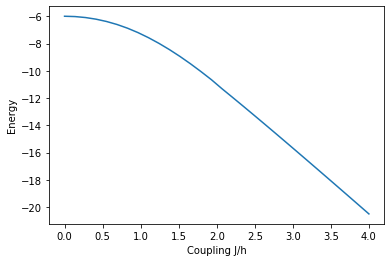

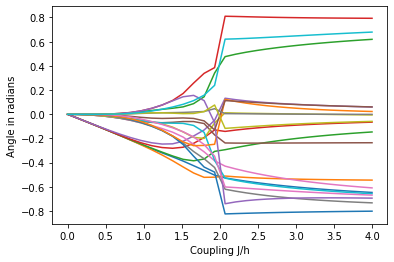

In [126]:
#adiabatic approach

gates = 20
J_min = 0
J_max = -4
span = 30

J_span = np.linspace(J_min, J_max, span)

angles = np.zeros((span, gates))
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
H_0 = H_manual(N, interactions_0)
interactions = [['X1X2',J_max],['X2X3',J_max],['X3X4',J_max],['X4X5',J_max],['X5X6',J_max]]
in_guess = np.array(gates*[0])
E = []
ansatz = ['QCA']
P_strings = inter(N, interactions, 12, gates).P_tensorproducts()
for i in range(len(J_span)):
    interactions = [['X1X2',J_span[i]],['X2X3',J_span[i]],['X3X4',J_span[i]],['X4X5',J_span[i]],['X5X6',J_span[i]]]
    H_1 = H_manual(N, interactions)
    H = H_0 + H_1
    eigenvalue_var, in_guess = VQa(H, ansatz,N, P_strings[:gates], in_guess)[1:3]
    angles[i,:] = in_guess
    E.append(eigenvalue_var)
plt.plot(-J_span, np.array(E))
plt.xlabel("Coupling J/h")
plt.ylabel("Energy")
plt.show()
for j in range(gates):
    plt.plot(-J_span, angles[:,j], label = "gate %s"%(j+1))
plt.xlabel("Coupling J/h")
plt.ylabel("Angle in radians")
plt.show()
    
    


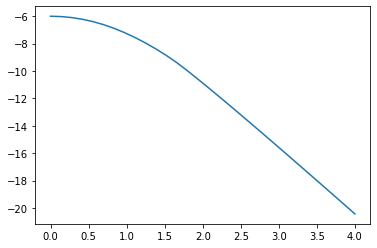

In [122]:
plt.plot(-J_span, np.array(E))
